# Integrating datasets with scVI in R


In this tutorial, we go over how to use basic scvi-tools functionality in R. However, for more involved analyses, we suggest using scvi-tools from Python. Checkout the [Scanpy_in_R tutorial](https://theislab.github.io/scanpy-in-R/#converting-from-r-to-python-1) for instructions on converting Seurat objects to anndata. 

This tutorial requires Reticulate. Please check out our installation guide for instructions on installing Reticulate and scvi-tools.

## Loading and processing data with Seurat
We follow the basic Seurat [tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html) for loading data and selecting highly variable genes.

**Note: scvi-tools requires raw gene expression**

In [1]:
# devtools::install_github("satijalab/seurat-data")
# SeuratData::InstallData("pbmc3k")
# install.packages("https://seurat.nygenome.org/src/contrib/ifnb.SeuratData_3.0.0.tar.gz", repos = NULL, type = "source") 
# SeuratData::InstallData("ifnb")# devtools::install_github("cellgeni/sceasy")

In [ ]:
library(Seurat)
library(SeuratData)
library(cowplot)
library(reticulate)
library(sceasy)
SeuratData::InstallData("pbmc3k")
SeuratData::InstallData("ifnb")

In [3]:
use_condaenv("base", required = TRUE)

In [4]:
# We will work within the Seurat framework
data("pbmc3k")
pbmc <- pbmc3k

In [ ]:
pbmc = UpdateSeuratObject(object = pbmc) 
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

In [6]:
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [7]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
top2000 <- head(VariableFeatures(pbmc), 2000)
pbmc <- pbmc[top2000]

In [8]:
print(pbmc) # Seurat object

An object of class Seurat 
2000 features across 2638 samples within 1 assay 
Active assay: RNA (2000 features, 2000 variable features)
 2 layers present: counts, data


## Converting Seurat object to AnnData

scvi-tools relies on the [AnnData](https://anndata.readthedocs.io/en/latest/) object. Here we show how to convert our Seurat object to anndata for scvi-tools.



In [9]:
sc <- import("scanpy", convert = FALSE)
scvi <- import("scvi", convert = FALSE)

In [10]:
adata <- convertFormat(pbmc, from="seurat", to="anndata", main_layer="counts", drop_single_values=FALSE)
print(adata) # Note generally in Python, dataset conventions are obs x var

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the sceasy package.
  Please report the issue to the authors.”


AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_annotations', 'percent.mt'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'


## Setup our AnnData for training

Reticulate allows us to call Python code from R, giving the ability to use all of scvi-tools in R. We encourage you to checkout their [documentation](https://rstudio.github.io/reticulate/articles/calling_python.html) and specifically the section on type conversions in order to pass arguments to Python functions.

In this section, we show how to setup the AnnData for scvi-tools, create the model, train the model, and get the latent representation. For a more in depth description of setting up the data, you can checkout our [introductory tutorial](https://www.scvi-tools.org/en/latest/user_guide/notebooks/api_overview.html) as well as our [data loading tutorial](https://www.scvi-tools.org/en/latest/user_guide/notebooks/data_loading.html). 


In [11]:
# run setup_anndata
scvi$model$SCVI$setup_anndata(adata)

# create the model
model = scvi$model$SCVI(adata)

# train the model
model$train()

# to specify the number of epochs when training:
# model$train(max_epochs = as.integer(400))


None

None

## Getting the latent represenation and visualization
Here we get the latent representation of the model and save it back in our Seurat object. Then we run UMAP and visualize. 

In [12]:
# get the latent represenation
latent = model$get_latent_representation()

# put it back in our original Seurat object
latent <- as.matrix(latent)
rownames(latent) = colnames(pbmc)
pbmc[["scvi"]] <- CreateDimReducObject(embeddings = latent, key = "scvi_", assay = DefaultAssay(pbmc))


Warning message:
“No columnames present in cell embeddings, setting to 'scvi_1:10'”


In [ ]:
# Find clusters, then run UMAP, and visualize
pbmc <- FindNeighbors(pbmc, dims = 1:10, reduction = "scvi")
pbmc <- FindClusters(pbmc, resolution =1)

pbmc <- RunUMAP(pbmc, dims = 1:10, reduction = "scvi", n.components = 2)

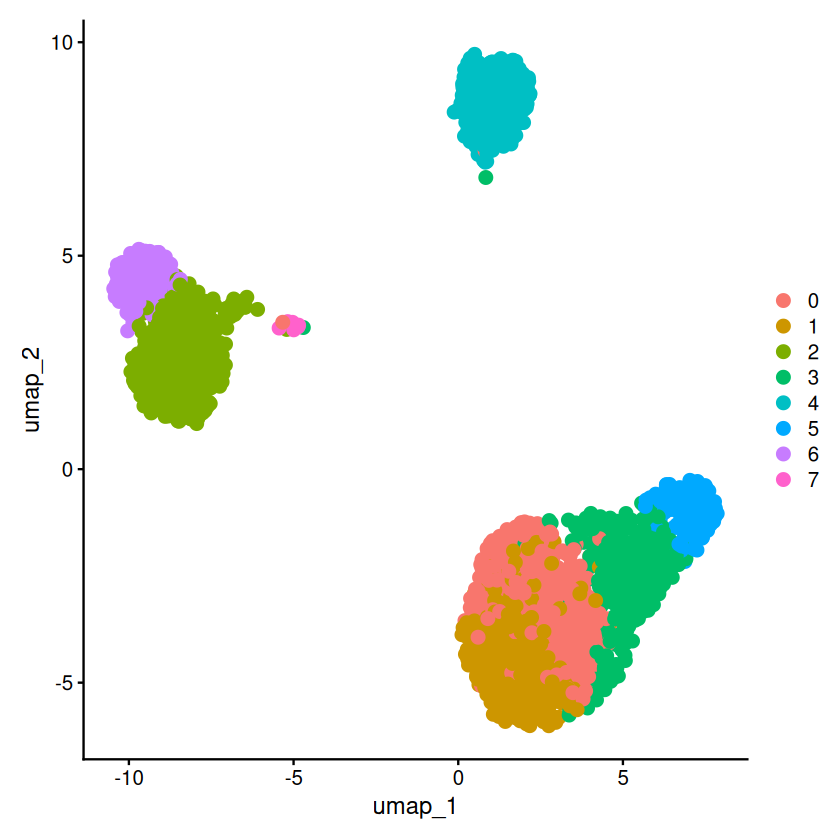

In [14]:
DimPlot(pbmc, reduction = "umap", pt.size = 3)

## Finding differentially expressed genes with scVI latent space

First, we put the seurat clusters into our original anndata.


In [15]:
adata$obs$insert(adata$obs$shape[1], "seurat_clusters", pbmc[["seurat_clusters"]][,1])

None

Using our trained SCVI model, we call the `differential_expression()` method
We pass `seurat_clusters` to the groupby argument and compare between cluster `1` and cluster `2`.

The output of DE is a DataFrame with the bayes factors. Bayes factors > 3 have high probability of being differentially expressed. You can also set fdr_target, which will return the differentially expressed genes based on the posteior expected FDR. 

In [16]:
DE <- model$differential_expression(adata, groupby="seurat_clusters", group1 = "1", group2 = "2")

In [17]:
print(DE$head())

        proba_m1  proba_m2  bayes_factor    scale1    scale2  raw_mean1  ...  non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  comparison  group1 group2
MALAT1    1.0000    0.0000     18.420681  0.132695  0.023147  82.504798  ...               1.000000           2132.539976            290.175165      1 vs 2       1      2
LTB       1.0000    0.0000     18.420681  0.007988  0.000383   4.545106  ...               0.259766            113.419735              4.415180      1 vs 2       1      2
CD27      0.9998    0.0002      8.516943  0.001084  0.000044   0.577735  ...               0.029297             14.425546              0.299122      1 vs 2       1      2
IL32      0.9998    0.0002      8.516943  0.004273  0.000305   2.059501  ...               0.119141             50.971711              1.631069      1 vs 2       1      2
IL7R      0.9994    0.0006      7.417964  0.002590  0.000150   1.353167  ...               0.136719             32.595492              1.599910  

## Integrating datasets with scVI

Here we integrate two datasets from Seurat's [Immune Alignment Vignette](https://satijalab.org/seurat/v3.2/immune_alignment.html).

In [18]:
data("ifnb")

In [ ]:
# use seurat for variable gene selection 
ifnb = UpdateSeuratObject(object = ifnb) 
ifnb <- NormalizeData(ifnb, normalization.method = "LogNormalize", scale.factor = 10000)

In [20]:
ifnb[["percent.mt"]] <- PercentageFeatureSet(ifnb, pattern = "^MT-")
ifnb <- subset(ifnb, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
ifnb <- FindVariableFeatures(ifnb, selection.method = "vst", nfeatures = 2000)
top2000 <- head(VariableFeatures(ifnb), 2000)
ifnb <- ifnb[top2000]

In [21]:
adata <- convertFormat(ifnb, from="seurat", to="anndata", main_layer="counts", drop_single_values=FALSE)
print(adata)

AnnData object with n_obs × n_vars = 13997 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'percent.mt'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'


In [22]:
adata

AnnData object with n_obs × n_vars = 13997 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'percent.mt'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [23]:
# run setup_anndata, use column stim for batch
scvi$model$SCVI$setup_anndata(adata, batch_key = 'stim')

# create the model
model = scvi$model$SCVI(adata)

# train the model
model$train()

# to specify the number of epochs when training:
# model$train(max_epochs = as.integer(400))


None

None

In [24]:
# get the latent represenation
latent = model$get_latent_representation()

# put it back in our original Seurat object
latent <- as.matrix(latent)
rownames(latent) = colnames(ifnb)
ifnb[["scvi"]] <- CreateDimReducObject(embeddings = latent, key = "scvi_", assay = DefaultAssay(ifnb))

Warning message:
“No columnames present in cell embeddings, setting to 'scvi_1:10'”


In [ ]:
# for jupyter notebook
options(repr.plot.width=10, repr.plot.height=8)

ifnb <- RunUMAP(ifnb, dims = 1:10, reduction = "scvi", n.components = 2)
p1 <- DimPlot(ifnb, reduction = "umap", group.by = "stim", pt.size=2)

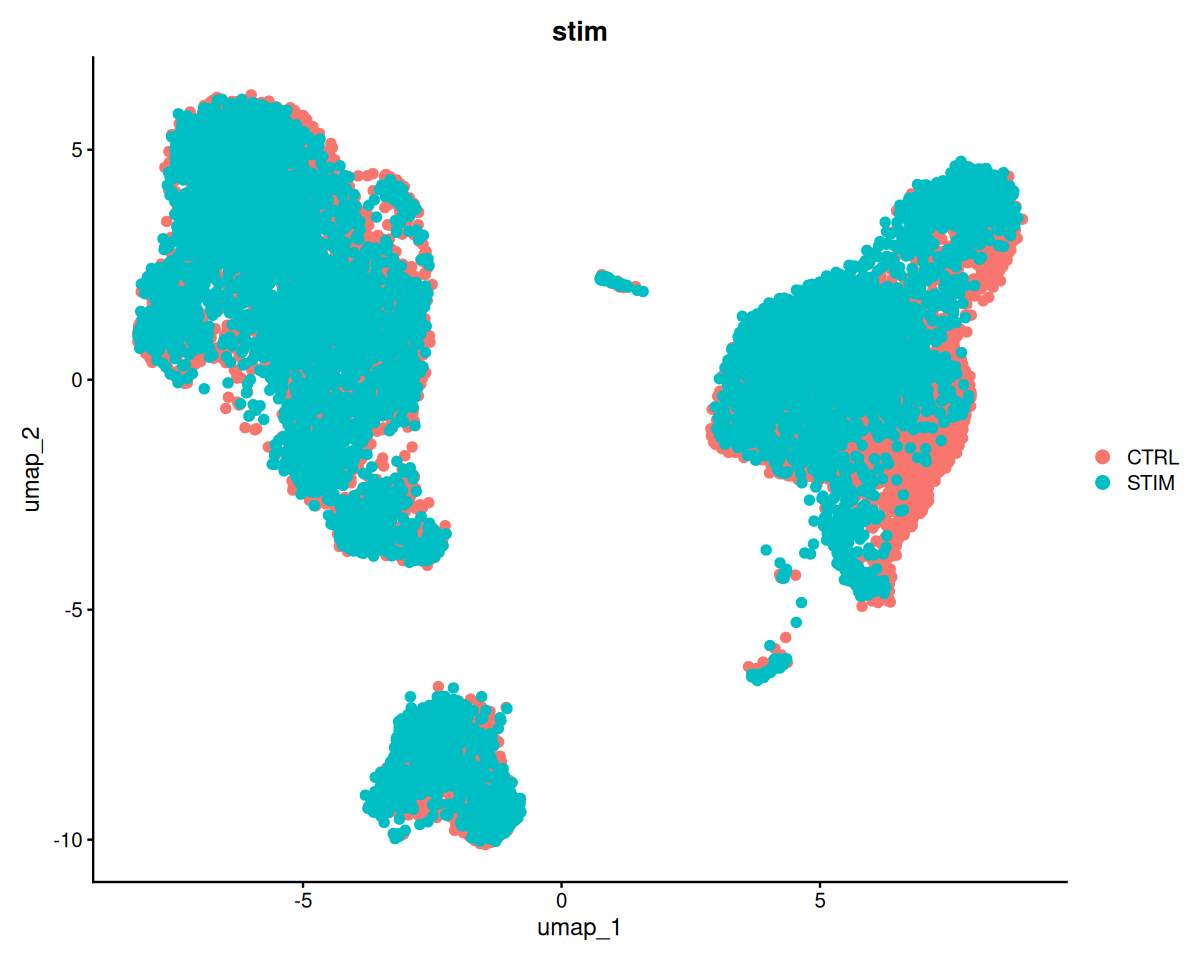

In [26]:
plot_grid(p1)

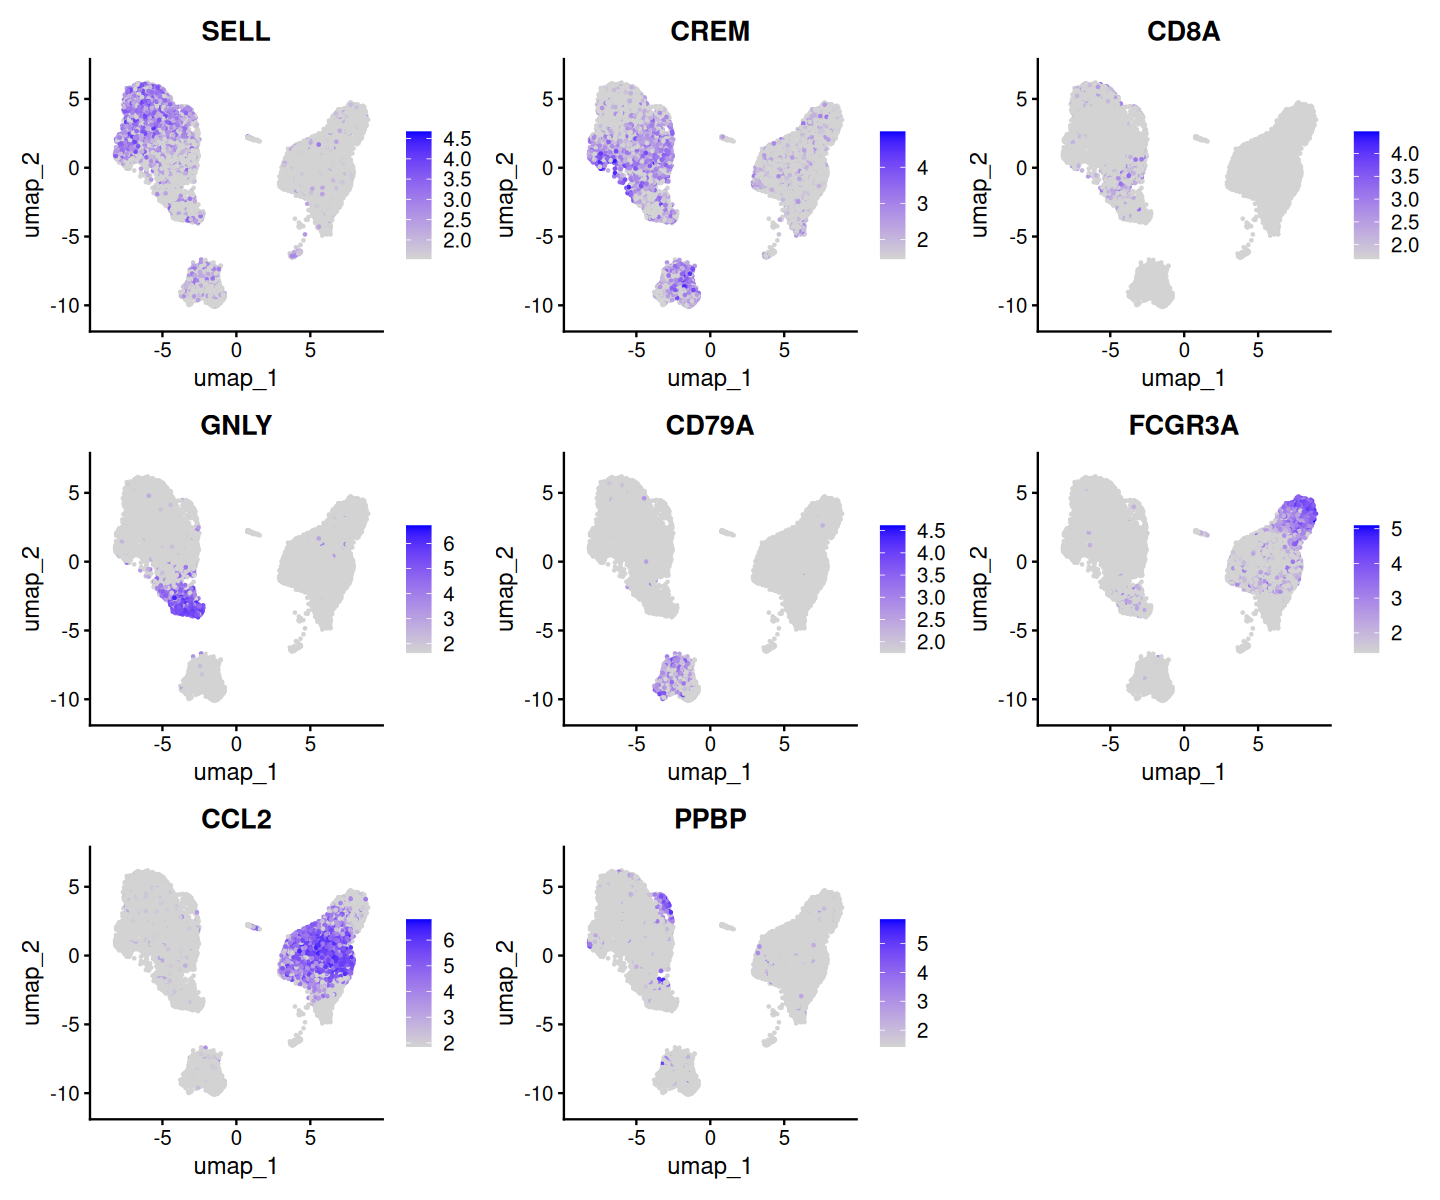

In [27]:
options(repr.plot.width=12, repr.plot.height=10)

FeaturePlot(ifnb, features = c("SELL", "CREM", "CD8A", "GNLY", "CD79A", "FCGR3A", 
    "CCL2", "PPBP"), min.cutoff = "q9")

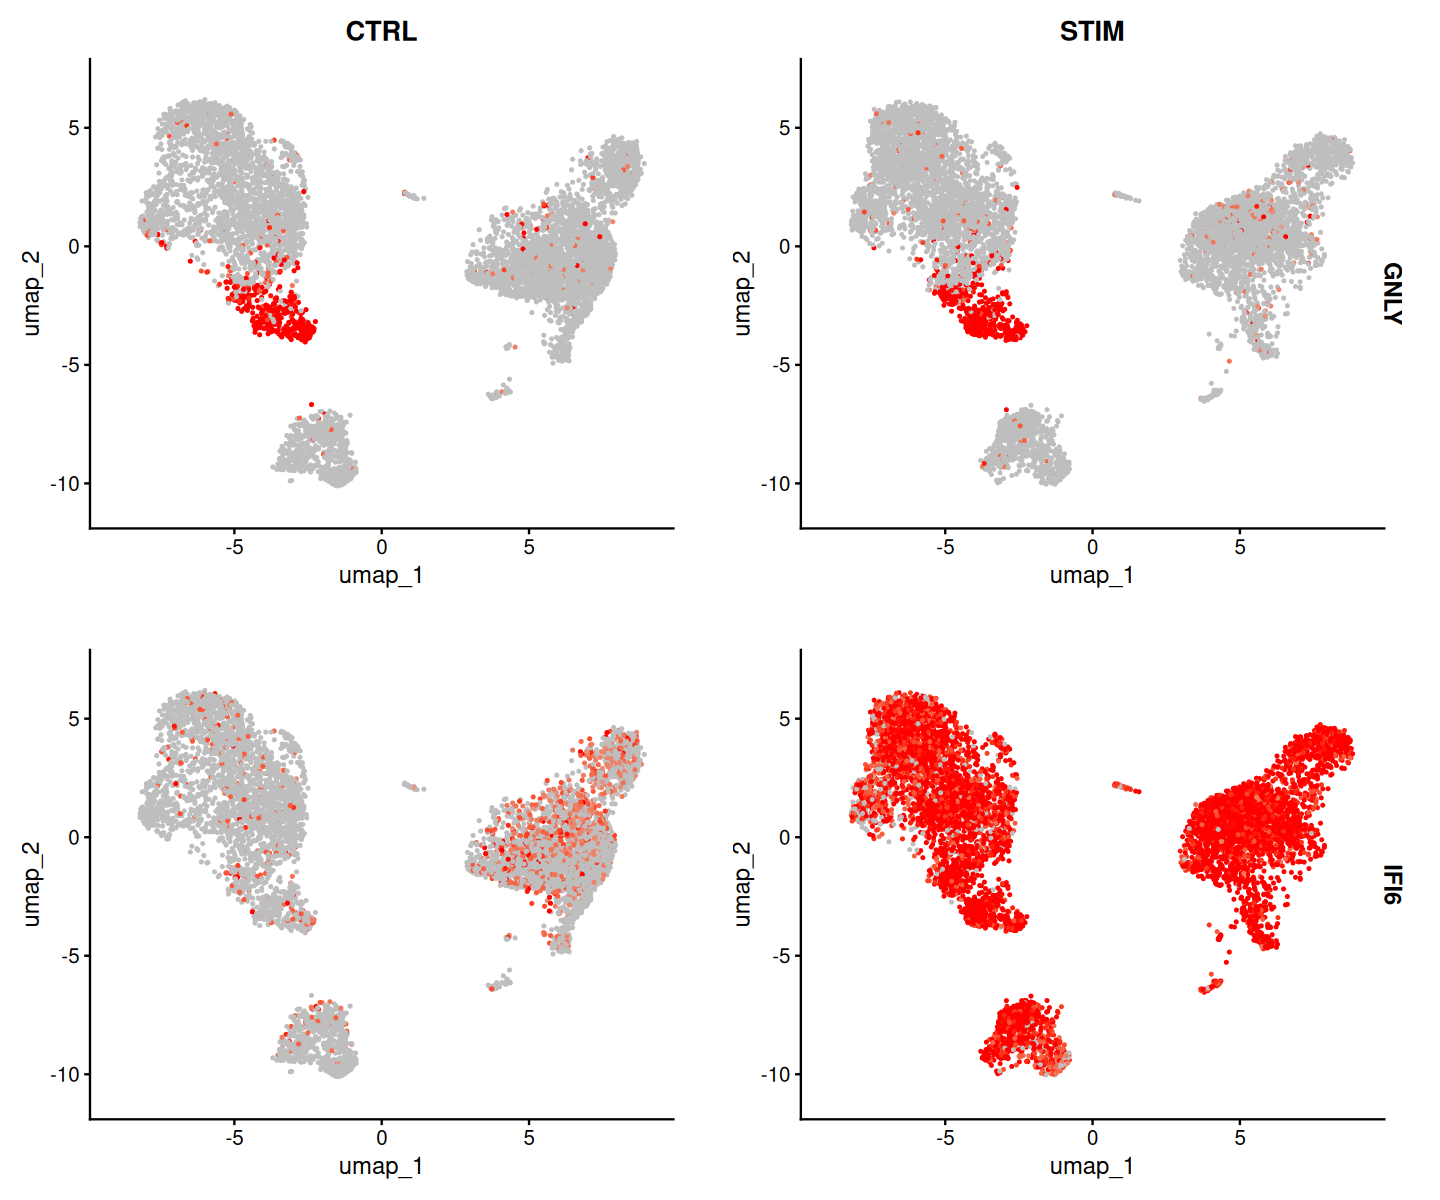

In [28]:
FeaturePlot(ifnb, features = c("GNLY", "IFI6"), split.by = "stim", max.cutoff = 3, 
    cols = c("grey", "red"))

#### Session Info Summary

In [29]:
sI <- sessionInfo()
sI$loadedOnly <- NULL
print(sI, locale=FALSE)

R version 4.3.3 (2024-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 24.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.12.0 
LAPACK: /opt/anaconda3/lib/libmkl_rt.so.2;  LAPACK version 3.10.1

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] future_1.67.0             sceasy_0.0.7             
 [3] reticulate_1.44.0         cowplot_1.2.0            
 [5] stxBrain.SeuratData_0.1.2 pbmc3k.SeuratData_3.1.4  
 [7] ifnb.SeuratData_3.0.0     SeuratData_0.2.2.9002    
 [9] Seurat_5.3.1              SeuratObject_5.2.0       
[11] sp_2.2-0                 
